Importing the required packages and modules

In [ ]:
import torch # importing torch
import torch.nn as nn # importing torcnn nn module
import torch.optim as optim # importing optimization tools
import torch.nn.functional as F # functions as F
import torchvision # importing torch vision to get the datasets
import torchvision.transforms as transforms # importing transforms
from sklearn.metrics import confusion_matrix # importing the confusion matrix
import seaborn as sn # for confusion matrix
import pandas as pd # for confusion matrix
import matplotlib.pyplot as plt # for confusion matrix
import numpy as np


Deciding the device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # checking if cuda is available


Defining the transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # using the standard transform

Obtaining the dataset and dataloader

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                             train=True,
                                             download=True,
                                             transform=transform) # Obtaining the CIFAR10 train_dataset

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=False,
                                            download=True,
                                            transform=transform) # Obtaining the CIFAR10 tests dataset


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True) # Train_dataloader

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1000,
                                          shuffle=False) # test_dataloader

100%|██████████| 170498071/170498071 [00:04<00:00, 38027940.30it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Defining VGG16 Class

In [ ]:
class VGG16(nn.Module): # defining the VGG16 class
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # Convolutional layers
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            # Fully connected layers
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x): # defining the forward function
        x = self.features(x)
        x = x.reshape(x.size(0), -1)
        x = self.classifier(x)
        return x


model = VGG16().to(device) # defining the model and moving it to device


Defining loss and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss() # as this is a classification, cross entropy loss has been used
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # using the adam optimizer with 0.001 as the learning rate

Defining Training Loop

In [ ]:
num_epochs = 50

def train_model(num_epochs, train_loader, model, criterion, optimizer, device): # defining train_model function to train the network

    model.train()

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Training the model

In [ ]:
train_model(num_epochs, train_loader, model, criterion, optimizer, device)

Epoch [1/50], Step [100/782], Loss: 2.2991
Epoch [1/50], Step [200/782], Loss: 2.3168
Epoch [1/50], Step [300/782], Loss: 2.1385
Epoch [1/50], Step [400/782], Loss: 2.0773
Epoch [1/50], Step [500/782], Loss: 1.9911
Epoch [1/50], Step [600/782], Loss: 1.9524
Epoch [1/50], Step [700/782], Loss: 1.8096
Epoch [2/50], Step [100/782], Loss: 1.8080
Epoch [2/50], Step [200/782], Loss: 1.8313
Epoch [2/50], Step [300/782], Loss: 1.7175
Epoch [2/50], Step [400/782], Loss: 1.8713
Epoch [2/50], Step [500/782], Loss: 1.8802
Epoch [2/50], Step [600/782], Loss: 1.6674


KeyboardInterrupt: 

Functions to test the model

In [ ]:
# Function for testing the model
def test_model(test_loader, model, device):
    model.eval()  # eval mode
    all_labels = []
    all_preds = []
    total=0
    correct=0

    with torch.no_grad(): # calculating the total number of correct predictions
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

    return all_labels, all_preds


In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    df_cm = pd.DataFrame(cm, index=[i for i in range(10)], columns=[i for i in range(10)])
    plt.figure(figsize=(10,7))
    sn.heatmap(df_cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


Testing the model

In [ ]:
all_labels, all_preds = test_model(test_loader, model, device)

Accuracy of the network on the test images: 31.04%


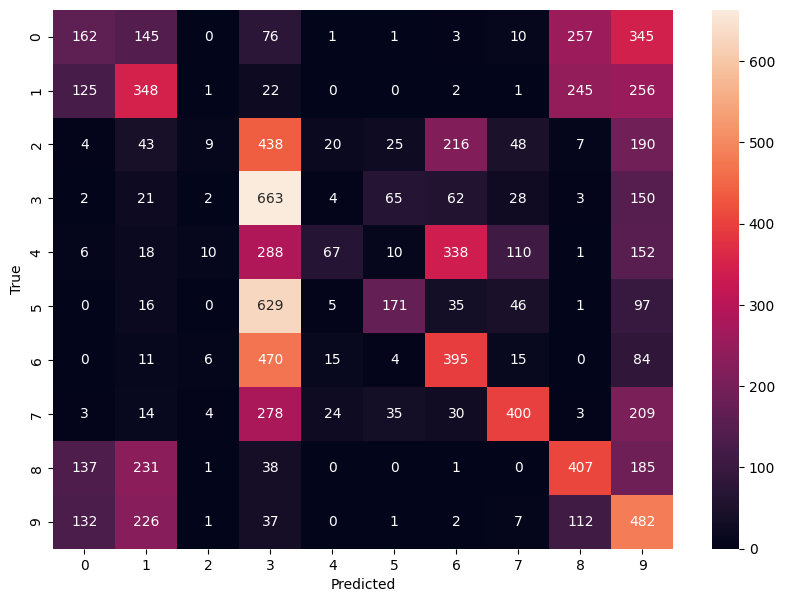

In [ ]:
plot_confusion_matrix(all_labels, all_preds)

Code for training and testing Vision Transformer on CIFAR10 dataset

In [ ]:
# Install dependencies
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 99.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from transformers import ViTFeatureExtractor, ViTModel

# Define hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 1
num_classes = 10  # Number of classes in CIFAR-10

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to ViT input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to ViT input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Load pre-trained ViT model and feature extractor
feature_extractor = ViTFeatureExtractor(model_type="google/vit-base-patch16-224")
model = ViTModel.from_pretrained("google/vit-base-patch16-224")

# Modify the classification head to match the number of classes in CIFAR-10
model.config.num_labels = num_classes  # Set the number of output classes

# Define a new classification head
classification_head = nn.Linear(model.config.hidden_size, num_classes)
nn.init.xavier_normal_(classification_head.weight)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(classification_head.parameters()), lr=learning_rate)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
classification_head.to(device)

# Start training
for epoch in range(num_epochs):
    total_loss = 0.0
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).last_hidden_state.mean(1)  # Average over sequence length and only the last but one layer
        logits = classification_head(outputs)  # Apply the head to the output features
        loss = criterion(logits, labels)
        loss.backward()  # Backpropagate the loss
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

print("Training finished!")

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


782


KeyboardInterrupt: 

In [ ]:
# Start the testing phase
with torch.no_grad():  # No backpropagation
    correct = 0  # Number of correct predictions
    total = 0  # Total length of predictions
    all_preds = []
    all_labels = []
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).last_hidden_state.mean(1)  # Average over sequence length
        logits = classification_head(outputs)
        correct += torch.sum(torch.argmax(logits, dim=1) == labels).detach().cpu().item()
        total += len(labels)
        all_preds.extend(torch.argmax(logits, dim=1).detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
    print(f"Test accuracy: {correct / total * 100:.2f}%")

In [ ]:
plot_confusion_matrix(all_preds, all_labels)

In [ ]:
# Adversarial attacks
# Noise attack
# Load pre-trained ViT model and feature extractor
# Start the testing phase
with torch.no_grad():  # No backpropagation
    correct = 0  # Number of correct predictions
    total = 0  # Total length of predictions
    all_preds = []
    all_labels = []
    for data in test_loader:
        inputs, labels = data
        inputs += torch.randn(inputs.shape)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).last_hidden_state.mean(1)  # Average over sequence length
        logits = classification_head(outputs)
        correct += torch.sum(torch.argmax(logits, dim=1) == labels).detach().cpu().item()
        total += len(labels)
        all_preds.extend(torch.argmax(logits, dim=1).detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
    print(f"Test accuracy: {correct / total * 100:.2f}%")